Primero se añaden las librerías necesarias

In [337]:
import pandas as pd
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
import emoji
import re
import seaborn as sns
import math
import collections
import numpy as np
from scipy import sparse
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score, recall_score
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
import scipy
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn import datasets, svm, metrics, model_selection
from sklearn.preprocessing import StandardScaler
import string as str
from collections import Counter
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import layers, models, losses, optimizers
from tensorflow.keras import models

Se lee el csv y se convierte en un dataframe

In [224]:
test = pd.read_csv('https://ml-coding-test.s3.eu-west-1.amazonaws.com/webis_test.csv', index_col=0)
train = pd.read_csv('https://ml-coding-test.s3.eu-west-1.amazonaws.com/webis_train.csv', index_col=0)

Se limpian los dataframes eliminando las filas con elementos vacíos y se resetean los índices

In [229]:
train = train.dropna().reset_index(drop=True)
test = test.dropna().reset_index(drop=True)

Se compara el numero total de tweets con clickbait con el número total de tweets sin clickbait,
solo en el dataframe de entrenamiento

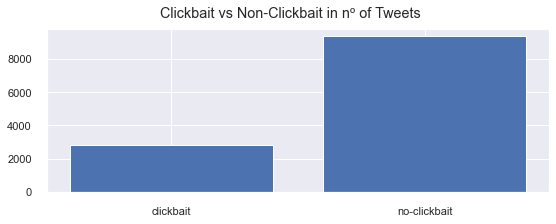

In [230]:
train_noncb = train[train['truthClass'] == 'no-clickbait']
train_cb = train[train['truthClass'] == 'clickbait']
names = ['clickbait', 'no-clickbait']
n_total_cb = train_cb.shape[0]
n_total_noncb = train_noncb.shape[0]
values = [n_total_cb, n_total_noncb]
plt.figure(figsize=(9, 3))
plt.bar(names, values)
plt.suptitle('Clickbait vs Non-Clickbait in nº of Tweets')
plt.show()

Para analizar el tipo de caracteres que hay en cada tweet se creean los siguientes dataframes secundarios

In [231]:
train_pT = train[['postText','truthClass']]
train_tP = train[['targetParagraphs','truthClass']]
train_tT = train[['targetTitle','truthClass']]
train_tK = train[['targetKeywords','truthClass']]
train_tD = train[['targetDescription','truthClass']]

Se pasan a una lista

In [232]:
train_df_list = [train_pT, train_tP, train_tT, train_tK, train_tD]

Una vez organizados en una lista se analiza uno por uno si tiene alguno de los siguientes caracteres:
'#, ?, !, @, ", numbers, emojis'. 
Si estos caracteres existen se marca un uno en la columna correspondiente asignada a cada símbolo.

In [233]:
for df in train_df_list:
    col = df[df.columns[0]]
    for row in col:
        #if isinstance(row, str):
        idx = df.index[col == row][0]
        #row = train['postText'][11]
        if '#' in row:
            df.at[idx, 'hash'] = 1
        else:
            df.at[idx, 'hash'] = 0
        if '?' in row:
            df.at[idx, 'question'] = 1
        else:
            df.at[idx, 'question'] = 0
        if '!' in row:
            df.at[idx, 'exclamation'] = 1
        else:
            df.at[idx, 'exclamation'] = 0
        if '@' in row:
            df.at[idx, 'at'] = 1
        else:
            df.at[idx, 'at'] = 0
        if '\"' in row:
            df.at[idx, 'quote'] = 1
        else:
            df.at[idx, 'quote'] = 0
        for character in row:
            if character.isdigit():
                df.at[idx, 'number'] = 1
                #row = row.replace(character, ' ')
            else:
                df.at[idx, 'number'] = 0
            if emoji.is_emoji(character):
                df.at[idx, 'emoji'] = 1
                #row = row.replace(character, ' ')
            else:
                df.at[idx, 'emoji'] = 0
        #row = row.replace('\n', ' ')
                    


C:\Users\Usuario\AppData\Local\Temp/ipykernel_7984/1440024649.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.at[idx, 'hash'] = 0
C:\Users\Usuario\AppData\Local\Temp/ipykernel_7984/1440024649.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.at[idx, 'question'] = 0
C:\Users\Usuario\AppData\Local\Temp/ipykernel_7984/1440024649.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveat

En el siguiente codigo se cuenta el numero de veces que aparece o no cada símbolo teniendo en cuenta el número total
de tweets y se representa en gráficas.

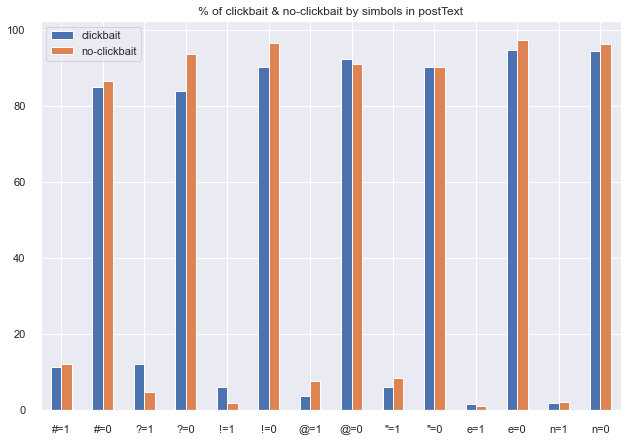

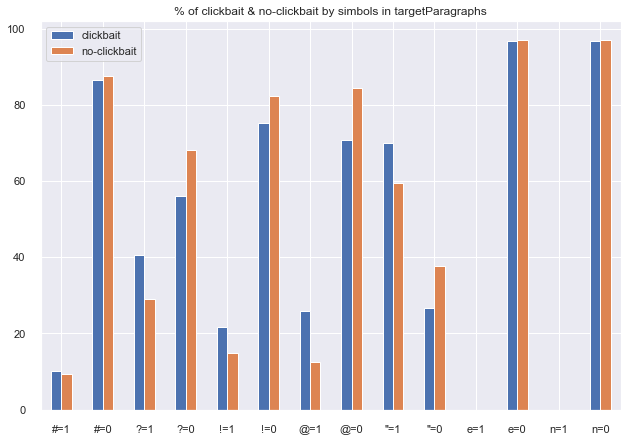

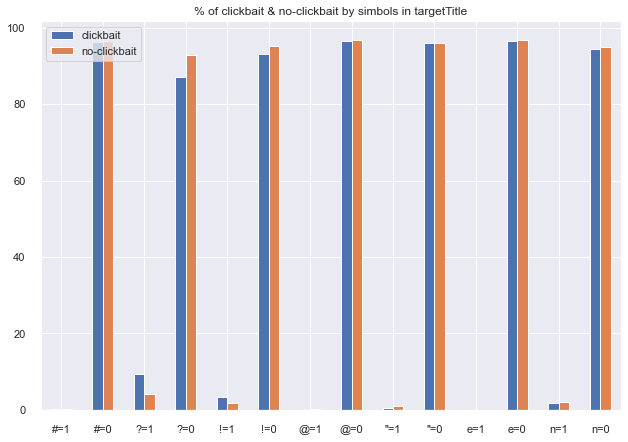

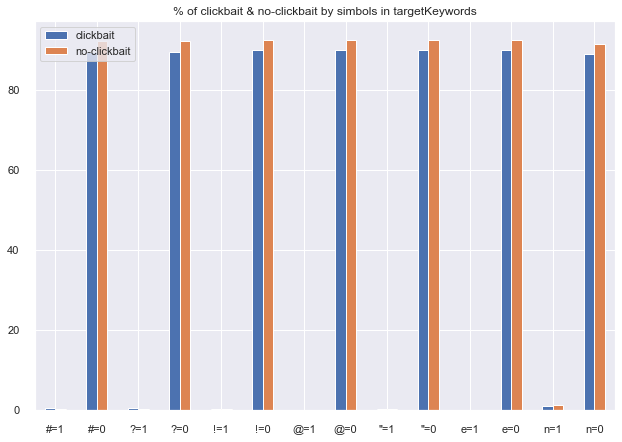

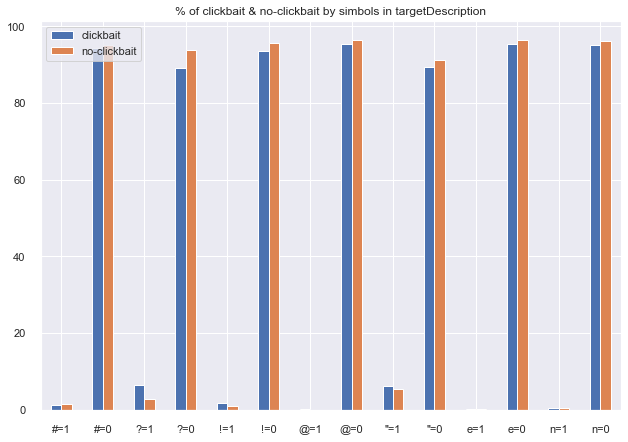

In [234]:
for df in train_df_list:
    
    cb_hash = (df['truthClass'] == 'clickbait')&(df['hash'] == 1)
    n_cb_hash = (df[cb_hash].shape[0]/n_total_cb)*100    
    cb_nonhash = (df['truthClass'] == 'clickbait')&(df['hash'] == 0)
    n_cb_nonhash = (df[cb_nonhash].shape[0]/n_total_cb)*100 

    cb_question = (df['truthClass'] == 'clickbait')&(df['question'] == 1)
    n_cb_question = (df[cb_question].shape[0]/n_total_cb)*100  
    cb_nonquestion = (df['truthClass'] == 'clickbait')&(df['question'] == 0)
    n_cb_nonquestion = (df[cb_nonquestion].shape[0]/n_total_cb)*100  

    cb_exclamation = (df['truthClass'] == 'clickbait')&(df['exclamation'] == 1)
    n_cb_exclamation = (df[cb_exclamation].shape[0]/n_total_cb)*100  
    cb_nonexclamation = (df['truthClass'] == 'clickbait')&(df['exclamation'] == 0)
    n_cb_nonexclamation = (df[cb_nonexclamation].shape[0]/n_total_cb)*100  

    cb_at = (df['truthClass'] == 'clickbait')&(df['at'] == 1)
    n_cb_at = (df[cb_at].shape[0]/n_total_cb)*100  
    cb_nonat = (df['truthClass'] == 'clickbait')&(df['at'] == 0)
    n_cb_nonat = (df[cb_nonat].shape[0]/n_total_cb)*100  

    cb_quote = (df['truthClass'] == 'clickbait')&(df['quote'] == 1)
    n_cb_quote = (df[cb_quote].shape[0]/n_total_cb)*100  
    cb_nonquote = (df['truthClass'] == 'clickbait')&(df['quote'] == 0)
    n_cb_nonquote = (df[cb_nonquote].shape[0]/n_total_cb)*100

    cb_emoji = (df['truthClass'] == 'clickbait')&(df['emoji'] == 1)
    n_cb_emoji = (df[cb_emoji].shape[0]/n_total_cb)*100 
    cb_nonemoji = (df['truthClass'] == 'clickbait')&(df['emoji'] == 0)
    n_cb_nonemoji = (df[cb_nonemoji].shape[0]/n_total_cb)*100   

    cb_number = (df['truthClass'] == 'clickbait')&(df['number'] == 1)
    n_cb_number = (df[cb_number].shape[0]/n_total_cb)*100 
    cb_nonnumber = (df['truthClass'] == 'clickbait')&(df['number'] == 0)
    n_cb_nonnumber = (df[cb_nonnumber].shape[0]/n_total_cb)*100   

    noncb_hash = (df['truthClass'] == 'no-clickbait')&(df['hash'] == 1)
    n_noncb_hash = (df[noncb_hash].shape[0]/n_total_noncb)*100 
    noncb_nonhash = (df['truthClass'] == 'no-clickbait')&(df['hash'] == 0)
    n_noncb_nonhash = (df[noncb_nonhash].shape[0]/n_total_noncb)*100 

    noncb_question = (df['truthClass'] == 'no-clickbait')&(df['question'] == 1)
    n_noncb_question = (df[noncb_question].shape[0]/n_total_noncb)*100 
    noncb_nonquestion = (df['truthClass'] == 'no-clickbait')&(df['question'] == 0)
    n_noncb_nonquestion = (df[noncb_nonquestion].shape[0]/n_total_noncb)*100 

    noncb_exclamation = (df['truthClass'] == 'no-clickbait')&(df['exclamation'] == 1)
    n_noncb_exclamation = (df[noncb_exclamation].shape[0]/n_total_noncb)*100 
    noncb_nonexclamation = (df['truthClass'] == 'no-clickbait')&(df['exclamation'] == 0)
    n_noncb_nonexclamation = (df[noncb_nonexclamation].shape[0]/n_total_noncb)*100 

    noncb_at = (df['truthClass'] == 'no-clickbait')&(df['at'] == 1)
    n_noncb_at = (df[noncb_at].shape[0]/n_total_noncb)*100 
    noncb_nonat = (df['truthClass'] == 'no-clickbait')&(df['at'] == 0)
    n_noncb_nonat = (df[noncb_nonat].shape[0]/n_total_noncb)*100 

    noncb_quote = (df['truthClass'] == 'no-clickbait')&(df['quote'] == 1)
    n_noncb_quote = (df[noncb_quote].shape[0]/n_total_noncb)*100 
    noncb_nonquote = (df['truthClass'] == 'no-clickbait')&(df['quote'] == 0)
    n_noncb_nonquote = (df[noncb_nonquote].shape[0]/n_total_noncb)*100

    noncb_emoji = (df['truthClass'] == 'no-clickbait')&(df['emoji'] == 1)
    n_noncb_emoji = (df[noncb_emoji].shape[0]/n_total_noncb)*100 
    noncb_nonemoji = (df['truthClass'] == 'no-clickbait')&(df['emoji'] == 0)
    n_noncb_nonemoji = (df[noncb_nonemoji].shape[0]/n_total_noncb)*100 

    noncb_number = (df['truthClass'] == 'no-clickbait')&(df['number'] == 1)
    n_noncb_number = (df[noncb_number].shape[0]/n_total_noncb)*100 
    noncb_nonnumber = (df['truthClass'] == 'no-clickbait')&(df['number'] == 0)
    n_noncb_nonnumber = (df[noncb_nonnumber].shape[0]/n_total_noncb)*100 
    
    n_cb = [n_cb_hash, n_cb_nonhash, n_cb_question, n_cb_nonquestion, n_cb_exclamation, n_cb_nonexclamation, 
            n_cb_at, n_cb_nonat, n_cb_quote, n_cb_nonquote, n_cb_emoji, n_cb_nonemoji, n_cb_number, n_cb_nonnumber]

    n_noncb = [n_noncb_hash, n_noncb_nonhash, n_noncb_question, n_noncb_nonquestion, n_noncb_exclamation, n_noncb_nonexclamation,
               n_noncb_at, n_noncb_nonat, n_noncb_quote, n_noncb_nonquote, n_noncb_emoji, n_noncb_nonemoji, n_noncb_number, n_noncb_nonnumber]

    simbols = ['#=1', '#=0', '?=1', '?=0', '!=1', '!=0', '@=1', '@=0', '"=1', '"=0', 'e=1', 'e=0', 'n=1', 'n=0']
    
    title = "% of clickbait & no-clickbait by simbols in " + df.columns[0]
    
    df = pd.DataFrame({'clickbait': n_cb, 'no-clickbait': n_noncb}, index=simbols)    
    
    ax = df.plot.bar(title=title,rot=0)#,stacked=True)


En el caso de postText la aparición de '?, !, o emojis' indican que es más propable que sea clickbait,
por el contrario, que estos simbolos no estén presentes y que si lo esten '@ o "' indica que es más 
probable que no sea clickbait.

Para targetParagraphs que se encuentren los siguientes caracteres '?, !, @ o "' es indicativo de clickbait,
su ausencia, por lo contrario, le da fiabilidad al tweet.

En targetTitle, encontramos algo similar, '? y !' indican que es más probable que sea clickbait, su ausencia
o la presencia de '"' indican que no lo sea.

TargetKeywords es una columna de información que no nos ayuda a distinguir si es o no clickbait.

Por último, targetDescription refuerza lo dicho, la presencia de '? o !' indica que probablemente sea clickbait.

Otro análisis que se puede hacer gira en torno a las palabras y no al tipo de caracteres.


In [236]:
train_targets = pd.DataFrame(columns=['index'])
for df in train_df_list:
    col = df[df.columns[0]].reset_index(drop=True)
    train_targets[df.columns[0]]=col

del train_targets["index"]
train_targets.head()

,postText,targetParagraphs,targetTitle,targetKeywords,targetDescription
0,UK’s response to modern slavery leaving victim...,['Thousands of modern slavery victims have\xa0...,‘Inexcusable’ failures in UK’s response to mod...,"modern slavery, Department For Work And Pensio...",“Inexcusable” failures in the UK’s system for ...
1,this is good,['President Donald Trump has appointed the\xa0...,Donald Trump Appoints Pro-Life Advocate as Ass...,"Americans United for Life, Dr. Charmaine Yoest...",President Donald Trump has appointed pro-life ...
2,"The ""forgotten"" Trump roast: Relive his brutal...",['When the\xa0White House correspondents’ dinn...,The ‘forgotten’ Trump roast: Relive his brutal...,"trump whcd, whcd, white house correspondents d...",President Trump won't be at this year's White ...
3,Meet the happiest #dog in the world!,['Adorable is probably an understatement. This...,"Meet The Happiest Dog In The World, Maru The H...","Maru, husky, dogs, pandas, furball, instagram","The article is about Maru, a husky dog who has..."
4,Tokyo's subway is shut down amid fears over an...,"[""One of Tokyo's major subways systems says it...",Tokyo's subway is shut down amid fears over an...,"Tokyo,subway,shut,fears,North,Korean,attack","The temporary suspension, which lasted ten min..."


Debemos eliminar los emojis

In [237]:
emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags=re.UNICODE)

En resumen, solo queremos letras, en minúscula sin ningún tipo de puntuación.

In [238]:
for col in train_targets:
    train_targets[col] = train_targets[col].apply(lambda x: re.sub(r"[^a-zA-Z]", ' ', x.lower()))
    train_targets[col] = train_targets[col].apply(lambda x: emoji_pattern.sub(r'', x)) 
    train_targets[col] = train_targets[col].apply(lambda x: re.sub(r'\\', '', x)) 
    train_targets[col] = train_targets[col].apply(lambda x: re.sub(' +', ' ', x))


Lo siguiente es tokenizar el texto

In [239]:
train_targets.postText = tokenize(train_targets.postText)
train_targets.targetParagraphs = tokenize(train_targets.targetParagraphs)
train_targets.targetTitle = tokenize(train_targets.targetTitle)
train_targets.targetKeywords = tokenize(train_targets.targetKeywords)
train_targets.targetDescription = tokenize(train_targets.targetDescription)


Y finalmente eliminamos las palabras que no aportan significado (stopwords)

In [ ]:
nltk.download('stopwords')
nltk.download('punkt')

def tokenize(text):
    text = [word_tokenize(x) for x in text]
    return text

stopwords_list = stopwords.words('english')

In [240]:
train_targets.postText = train_targets['postText'].apply(lambda x: [item for item in x if item not in stopwords_list])
train_targets.targetParagraphs = train_targets['targetParagraphs'].apply(lambda x: [item for item in x if item not in stopwords_list])
train_targets.targetTitle = train_targets['targetTitle'].apply(lambda x: [item for item in x if item not in stopwords_list])
train_targets.targetKeywords = train_targets['targetKeywords'].apply(lambda x: [item for item in x if item not in stopwords_list])
train_targets.targetDescription = train_targets['targetDescription'].apply(lambda x: [item for item in x if item not in stopwords_list])


In [241]:
train_targets[train_df_list[0].columns[1]] = train_df_list[0][train_df_list[0].columns[1]] 
train_targets.head()

,postText,targetParagraphs,targetTitle,targetKeywords,targetDescription,truthClass
0,"[uk, response, modern, slavery, leaving, victi...","[thousands, modern, slavery, victims, xa, come...","[inexcusable, failures, uk, response, modern, ...","[modern, slavery, department, work, pensions, ...","[inexcusable, failures, uk, system, dealing, m...",no-clickbait
1,[good],"[president, donald, trump, appointed, xa, pro,...","[donald, trump, appoints, pro, life, advocate,...","[americans, united, life, dr, charmaine, yoest...","[president, donald, trump, appointed, pro, lif...",clickbait
2,"[forgotten, trump, roast, relive, brutal, thra...","[xa, white, house, correspondents, dinner, xa,...","[forgotten, trump, roast, relive, brutal, thra...","[trump, whcd, whcd, white, house, corresponden...","[president, trump, year, white, house, corresp...",no-clickbait
3,"[meet, happiest, dog, world]","[adorable, probably, understatement, adorable,...","[meet, happiest, dog, world, maru, husky, also...","[maru, husky, dogs, pandas, furball, instagram]","[article, maru, husky, dog, uncanny, resemblan...",clickbait
4,"[tokyo, subway, shut, amid, fears, imminent, n...","[one, tokyo, major, subways, systems, says, sh...","[tokyo, subway, shut, amid, fears, imminent, n...","[tokyo, subway, shut, fears, north, korean, at...","[temporary, suspension, lasted, ten, minutes, ...",no-clickbait


Una vez hemos limpiado los datos, los dividimos en dos dataframes en función de si tiene o no cb.

In [242]:
tt_cb = train_targets[train_targets['truthClass'] == 'clickbait']
del tt_cb['truthClass']
tt_noncb = train_targets[train_targets['truthClass'] == 'no-clickbait']
del tt_noncb['truthClass']

Se cuenta cuanto aparece cada palabra para poder analizar cuales son las más frecuentes.

In [243]:
lists_cb = []
for col in tt_cb:
    lists_cb.append(list(tt_cb[col]))

total_vocab_cb = set()
for list_cb in lists_cb:
    for word in list_cb:
        total_vocab_cb.update(word)
    #print(len(total_vocab_cb))

In [244]:
lists_noncb = []
for col in tt_noncb:
    lists_noncb.append(list(tt_noncb[col]))

total_vocab_noncb = set()
for list_noncb in lists_noncb:
    for word in list_noncb:
        total_vocab_noncb.update(word)
    #print(len(total_vocab_noncb))

C:\Users\Usuario\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


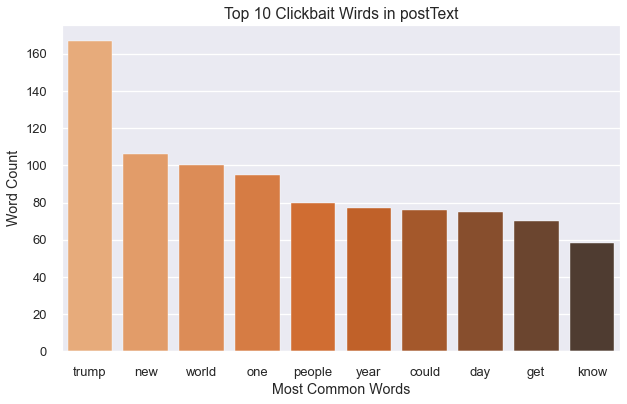

C:\Users\Usuario\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


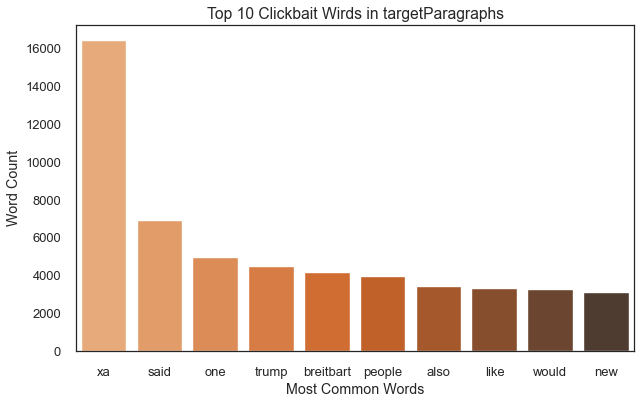

C:\Users\Usuario\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


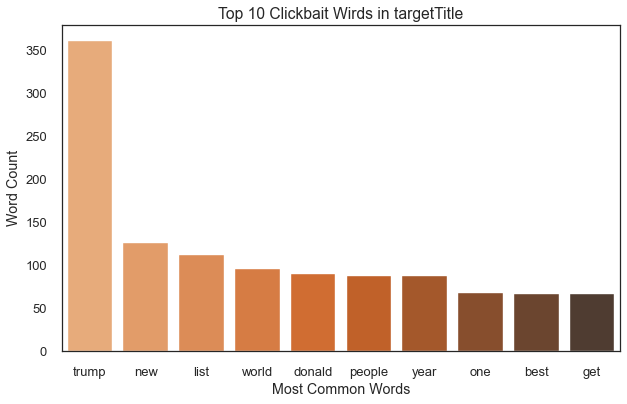

C:\Users\Usuario\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


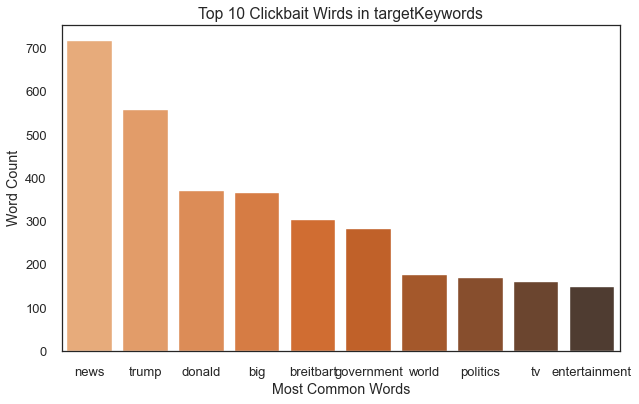

C:\Users\Usuario\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


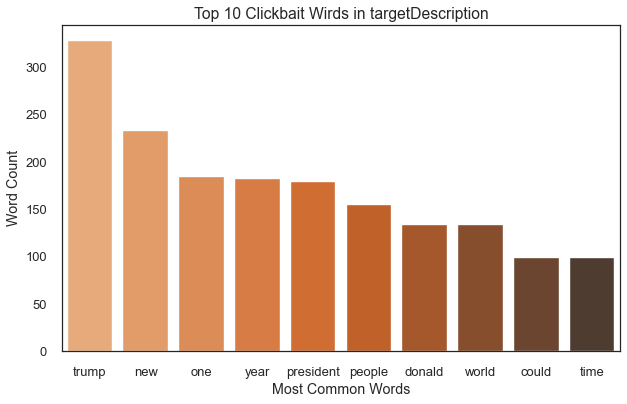

In [245]:
for list_cb in lists_cb:
    
    flat_cb = [item for sublist in list_cb for item in sublist]    
    cb_freq = FreqDist(flat_cb)    
    cb_bar_counts = [x[1] for x in cb_freq.most_common(10)]
    cb_bar_words = [x[0] for x in cb_freq.most_common(10)]
    
    index = lists_cb.index(list_cb)
    col_name = tt_cb.columns[index]    
    title = "Top 10 Clickbait Wirds in " + col_name
    
    plt.style.use('seaborn-talk')    
    word_freq_figure1 = plt.figure(figsize=(10,6))
    sns.barplot(cb_bar_words, cb_bar_counts,palette='Oranges_d')    
    plt.title(title)
    plt.xlabel('Most Common Words')
    plt.ylabel('Word Count')
    sns.set_style('white')
    plt.show()

C:\Users\Usuario\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


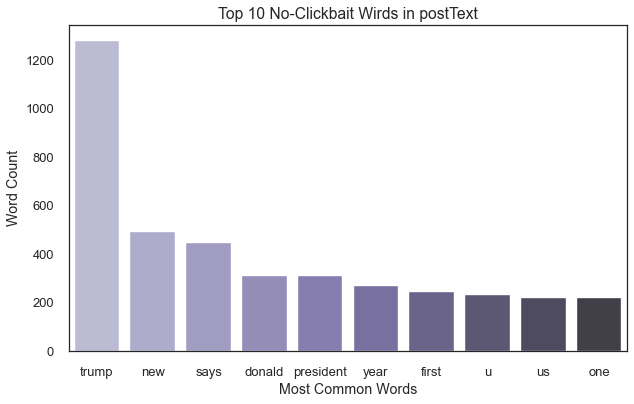

C:\Users\Usuario\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


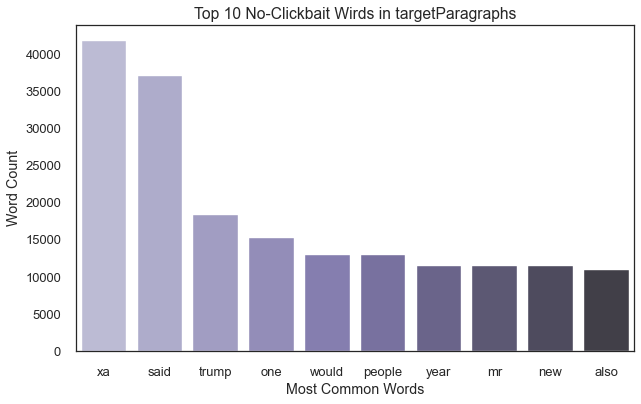

C:\Users\Usuario\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


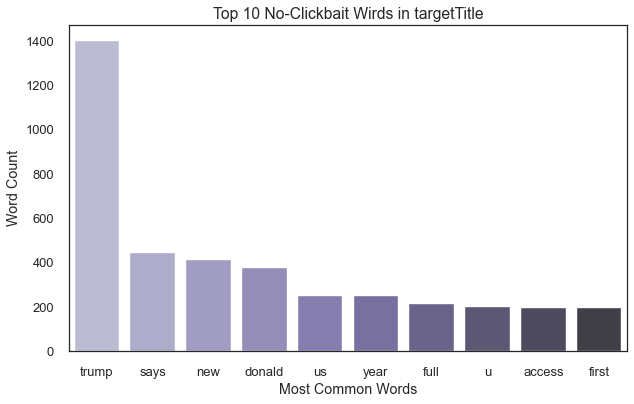

C:\Users\Usuario\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


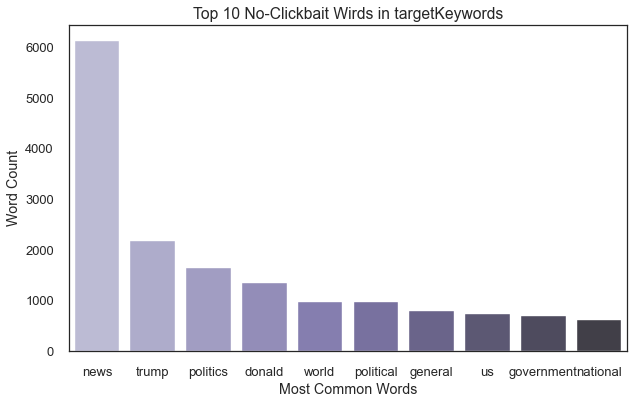

C:\Users\Usuario\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


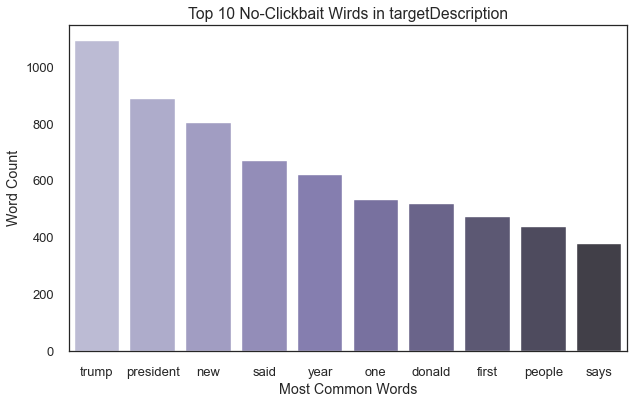

In [246]:
for list_noncb in lists_noncb:
    
    flat_noncb = [item for sublist in list_noncb for item in sublist]    
    noncb_freq = FreqDist(flat_noncb)    
    noncb_bar_counts = [x[1] for x in noncb_freq.most_common(10)]
    noncb_bar_words = [x[0] for x in noncb_freq.most_common(10)]
    
    index = lists_noncb.index(list_noncb)
    col_name = tt_noncb.columns[index]    
    title = "Top 10 No-Clickbait Wirds in " + col_name
    
    plt.style.use('seaborn-talk')    
    word_freq_figure1 = plt.figure(figsize=(10,6))
    sns.barplot(noncb_bar_words, noncb_bar_counts, palette='Purples_d')    
    plt.title(title)
    plt.xlabel('Most Common Words')
    plt.ylabel('Word Count')
    sns.set_style('white')
    plt.show()
    

In [247]:
from wordcloud import WordCloud
clickbait_dictionary = dict(zip(cb_bar_words, cb_bar_counts))
nonclickbait_dictionary = dict(zip(noncb_bar_words, noncb_bar_counts))

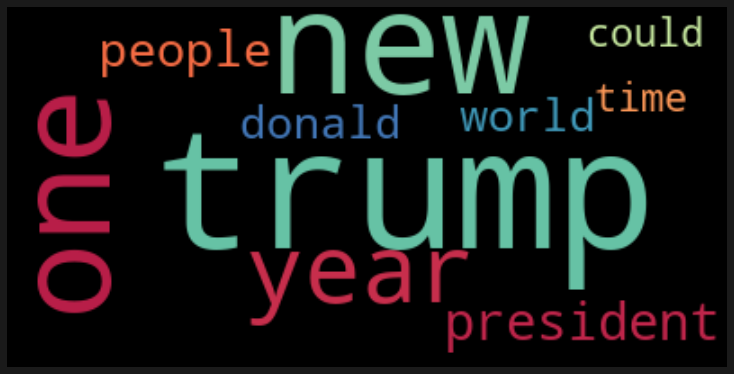

In [248]:
wordcloud = WordCloud(colormap='Spectral').generate_from_frequencies(clickbait_dictionary)

plt.figure(figsize=(10,10), facecolor='k')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

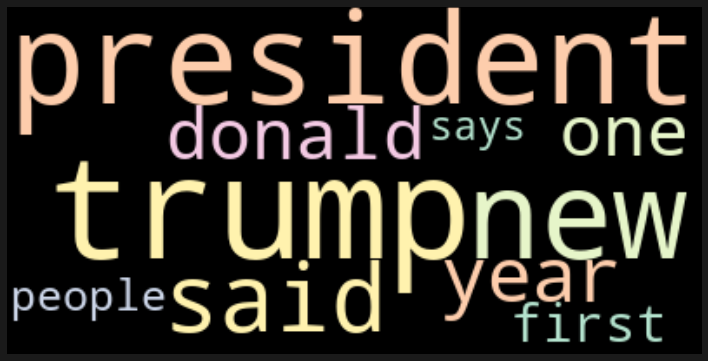

In [249]:
wordcloud = WordCloud(colormap='Pastel2').generate_from_frequencies(nonclickbait_dictionary)
plt.figure(figsize=(10,10), facecolor='k')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)
plt.tight_layout()
plt.show()

En este caso las palabras no nos ayudan a diferencia cuando se trata de clickbait o no.

Analizados el tipo de caracteres y las palabras podemos analizar el número de palabras.

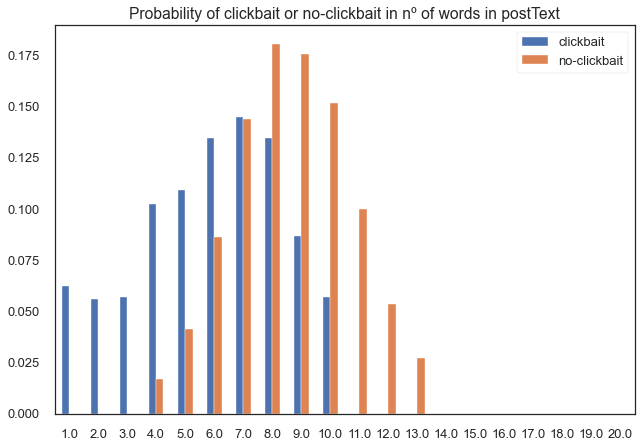

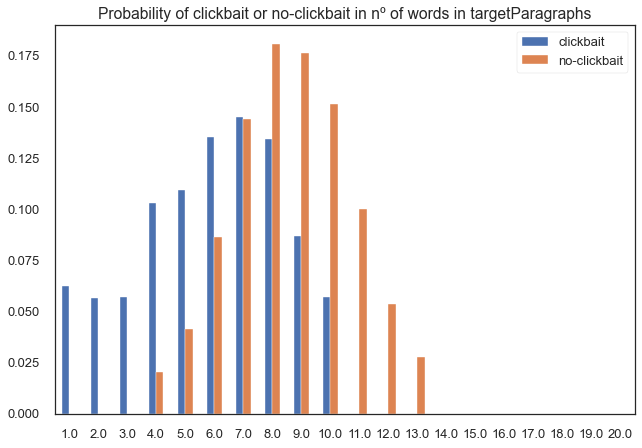

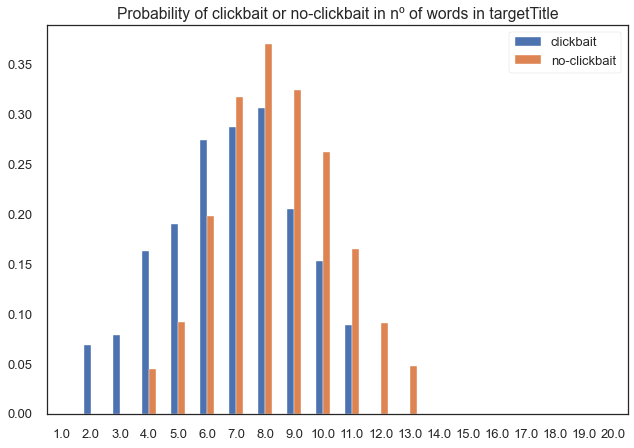

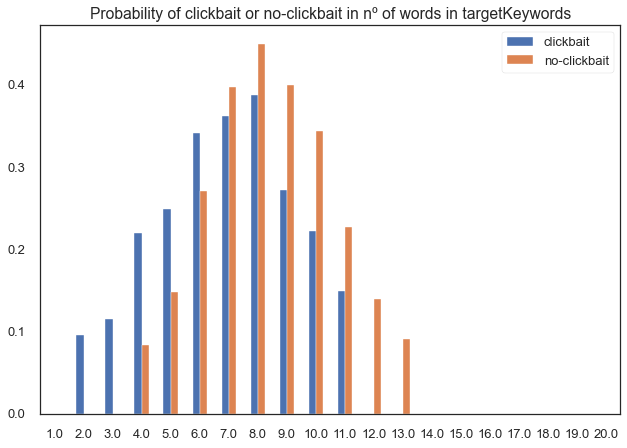

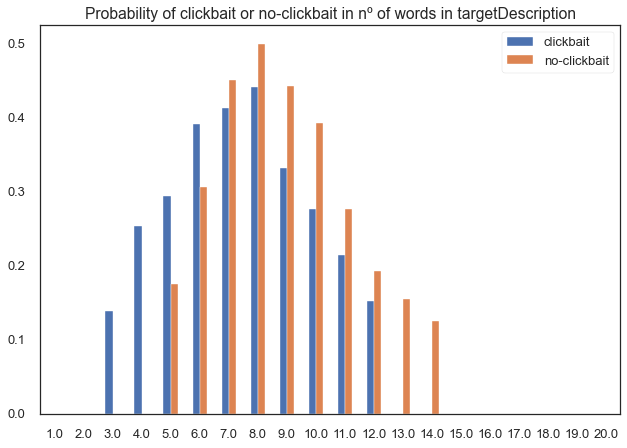

In [250]:
lengths_rows_cb = []
lengths_rows_noncb = []

for col in tt_cb:
    
    for row in tt_cb[col]:
        lengths_rows_cb.append(len(row))
        
    for row in tt_noncb[col]:
        lengths_rows_noncb.append(len(row))
        
    counter_cb=collections.Counter(lengths_rows_cb)
    counter_noncb=collections.Counter(lengths_rows_noncb)
    
    dict_most_common_lengths_cb = dict(counter_cb.most_common(10))
    dict_most_common_lengths_noncb = dict(counter_noncb.most_common(10))
    
    bins = np.linspace(1, 20, 20)
    
    l_length_freq_cb_values = []
    l_length_freq_noncb_values = []
    
    for i in list(bins):
        
        if i in dict_most_common_lengths_cb.keys():
            l_length_freq_cb_values.append(dict_most_common_lengths_cb[i]/n_total_cb)
        else:
            l_length_freq_cb_values.append(0)
            
        if i in dict_most_common_lengths_noncb.keys():
            l_length_freq_noncb_values.append(dict_most_common_lengths_noncb[i]/n_total_noncb)
        else:
            l_length_freq_noncb_values.append(0)
    
    title = "Probability of clickbait or no-clickbait in nº of words in " + col
    
    df = pd.DataFrame({'clickbait': l_length_freq_cb_values, 'no-clickbait': l_length_freq_noncb_values}, index=list(bins))    

    ax = df.plot.bar(title=title,rot=0)

La conclusión que sacamos de las gráficas anteriores, es que en el caso de clickbait siempre hay menos palabras.

En resumen, lo que más nos va a ayudar a la hora de clasificar entre clickbait o no es el tipo de caracteres
y lo menos útil son las palabras más frecuentes.

Sin embargo, las soluciones que he encontrado solo tienen en cuenta las palabras más frecuentes, en función de eso
presento la siguiente respuesta.

Lo primero es limpiar y preparar los datos.

In [294]:
def remove_punct(text):
    text = re.sub(r"[^a-zA-Z]", ' ', text.lower())
    return text

In [295]:
emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags=re.UNICODE)

In [296]:
def remove_emojis(text):
    text = emoji_pattern.sub(r'', text)
    return text

In [297]:
nltk.download('stopwords')
stop = set(stopwords.words("english"))

def remove_stopwords(text):
    filtered_words = [word.lower() for word in text.split() if word.lower() not in stop]
    return " ".join(filtered_words)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Usuario\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [342]:
def change_2_number(text):
    if text == 'no-clickbait':
        return 0
    else:
        return 1

In [343]:
train["postText"] = train.postText.map(remove_punct) # map(lambda x: remove_URL(x))
train["postText"] = train.postText.map(remove_emojis)
train["postText"] = train.postText.map(remove_stopwords)
train["truthClass"] = train.truthClass.map(change_2_number)

In [344]:
test["postText"] = test.postText.map(remove_punct) # map(lambda x: remove_URL(x))
test["postText"] = test.postText.map(remove_emojis)
test["postText"] = test.postText.map(remove_stopwords)
test["truthClass"] = test.truthClass.map(change_2_number)

Lo siguiente contar la frecuencia de las palabras.

In [345]:
def counter_word(text_col):
    count = Counter()
    for text in text_col.values:
        for word in text.split():
            count[word] += 1
    return count

In [346]:
counter = counter_word(train.postText)

In [347]:
num_unique_words = len(counter)

In [348]:
train_sentences = train.postText.to_numpy()
train_labels = train.truthClass.to_numpy()
val_sentences = test.postText.to_numpy()
val_labels = test.truthClass.to_numpy()

Tokenizamos y convertimos en secuencias.

In [349]:
tokenizer = Tokenizer(num_words=num_unique_words)
tokenizer.fit_on_texts(train_sentences) 

In [350]:
word_index = tokenizer.word_index

In [351]:
train_sequences = tokenizer.texts_to_sequences(train_sentences)
val_sequences = tokenizer.texts_to_sequences(val_sentences)

In [352]:
max_length = 20

train_padded = pad_sequences(train_sequences, maxlen=max_length, padding="post", truncating="post")
val_padded = pad_sequences(val_sequences, maxlen=max_length, padding="post", truncating="post")


In [353]:
reverse_word_index = dict([(idx, word) for (word, idx) in word_index.items()])

In [354]:
def decode(sequence):
    return " ".join([reverse_word_index.get(idx, "?") for idx in sequence])

In [355]:
decoded_text = decode(train_sequences[10])

Creamos el modelo.

In [356]:
model = models.Sequential()
model.add(layers.Embedding(num_unique_words, 32, input_length=max_length))
model.add(layers.LSTM(64, dropout=0.1))
model.add(layers.Dense(1, activation="sigmoid"))


In [357]:
loss = losses.BinaryCrossentropy(from_logits=False)
optim = optimizers.Adam(lr=0.001)
metrics = ["accuracy"]

model.compile(loss=loss, optimizer=optim, metrics=metrics)

In [358]:
model.fit(train_padded, train_labels, epochs=20, validation_data=(val_padded, val_labels), verbose=2)

Epoch 1/20
382/382 - 11s - loss: 0.4652 - accuracy: 0.8007 - val_loss: 0.3996 - val_accuracy: 0.8259 - 11s/epoch - 28ms/step
Epoch 2/20
382/382 - 7s - loss: 0.3062 - accuracy: 0.8741 - val_loss: 0.4002 - val_accuracy: 0.8220 - 7s/epoch - 18ms/step
Epoch 3/20
382/382 - 6s - loss: 0.1901 - accuracy: 0.9280 - val_loss: 0.5097 - val_accuracy: 0.8020 - 6s/epoch - 16ms/step
Epoch 4/20
382/382 - 7s - loss: 0.1162 - accuracy: 0.9592 - val_loss: 0.6362 - val_accuracy: 0.7915 - 7s/epoch - 19ms/step
Epoch 5/20
382/382 - 6s - loss: 0.0745 - accuracy: 0.9759 - val_loss: 0.6660 - val_accuracy: 0.7848 - 6s/epoch - 16ms/step
Epoch 6/20
382/382 - 6s - loss: 0.0502 - accuracy: 0.9836 - val_loss: 0.9193 - val_accuracy: 0.7775 - 6s/epoch - 16ms/step
Epoch 7/20
382/382 - 6s - loss: 0.0357 - accuracy: 0.9890 - val_loss: 0.9446 - val_accuracy: 0.7889 - 6s/epoch - 16ms/step
Epoch 8/20
382/382 - 6s - loss: 0.0284 - accuracy: 0.9911 - val_loss: 1.2113 - val_accuracy: 0.7941 - 6s/epoch - 16ms/step
Epoch 9/20
382

Analizamos el resultado

In [359]:
predictions = model.predict(train_padded)
predictions = [1 if p > 0.5 else 0 for p in predictions]

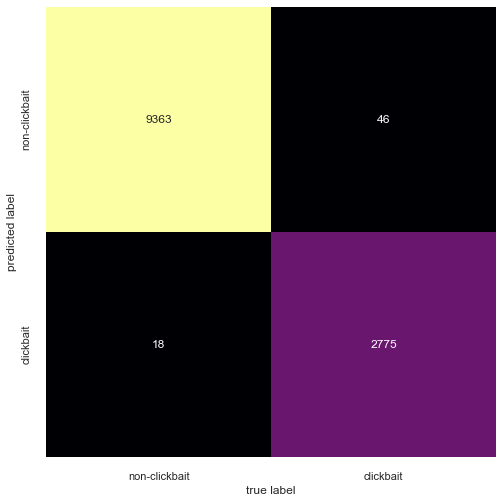

In [365]:
sns.set()

cm_dc = confusion_matrix(train_labels, predictions)
sns.heatmap(cm_dc.T, square=True, annot=True, fmt='d', cbar=False,cmap="inferno", xticklabels=['non-clickbait','clickbait'],yticklabels=['non-clickbait','clickbait']
            )
plt.xlabel('true label')
plt.ylabel('predicted label');
plt.tight_layout()
plt.savefig('dc_cm')